<a href="https://colab.research.google.com/github/alex-smith-uwec/CS491/blob/main/word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import string

import nltk
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
# stop_words=()#so no stopword removal

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
my_path="/content/drive/MyDrive/CS491/Data/US_Inaugural_Addresses"

In [4]:
# Assuming all your text files are in the 'inauguration_speeches' directory
directory = my_path
all_files = os.listdir(directory)


In [5]:
combined_text = "" # This will store all text combined from all files

for filename in all_files:
    filepath = os.path.join(directory, filename)
    with open(filepath, 'r', encoding='utf-8') as file:
        text = file.read()
        combined_text += text + " " # Ensure there's space between texts

# Use NLTK's sent_tokenize to split the combined text into sentences

In [6]:
sentences = sent_tokenize(combined_text)

In [7]:
tokenized_sentences = []
for sentence in sentences:
    # Tokenize each sentence into words and apply lowercasing
    words = word_tokenize(sentence.lower())
    # Remove stopwords
    words_filtered = [word for word in words if word not in stop_words and word.isalpha()]  # isalpha() helps remove punctuation
    tokenized_sentences.append(words_filtered)


In [8]:
tokenized_sentences[-2]

['may', 'god', 'bless', 'america', 'may', 'god', 'protect', 'troops']

In [9]:
model = Word2Vec(tokenized_sentences, vector_size=200, window=5, min_count=5, workers=2, epochs=200)

In [10]:
len(model.wv.index_to_key)

2614

In [11]:
# After training, you can use the model to find similar words, etc.
model.wv.most_similar('citizen',topn=10)

[('rights', 0.29797250032424927),
 ('member', 0.2731863856315613),
 ('society', 0.26164141297340393),
 ('person', 0.2604566514492035),
 ('star', 0.25825363397598267),
 ('violate', 0.256229966878891),
 ('section', 0.2445099800825119),
 ('portion', 0.24347129464149475),
 ('sacredly', 0.24227015674114227),
 ('thoughtful', 0.24112500250339508)]

In [12]:
# Example words
word1 = "liberty"
word2 = "justice"
word3=  "war"

# Get the vector for each word
vector1 = model.wv[word1]
vector2 = model.wv[word2]
vector3=model.wv[word3]

# Add the vectors
linear_comb = vector1-2*vector2+1*vector3

# You can now use the resulting vector to find similar words, for example
# similar_words = model.wv.similar_by_vector(linear_comb,topn=2)

similar_words = model.wv.similar_by_vector(linear_comb,topn=4)
print(similar_words)

[('war', 0.44189807772636414), ('liberty', 0.37858131527900696), ('birth', 0.21055492758750916), ('homes', 0.20252369344234467)]


# Plotting word embedding

In [18]:
# Extract a slice of word vectors, useful if we need to reduce for plotting
words = list(model.wv.index_to_key[0:])  # Adjust the slice for the number of words you want
word_vectors = [model.wv[word] for word in words]

len(word_vectors)

2614

In [13]:
##Use after plot rendered to extract words in a region of the plot
def find_words_in_grid(embeddings, words, x_min, x_max, y_min, y_max):
    """
    Finds and returns the words that are located within a specified grid area.

    Parameters:
    - embeddings: numpy array of shape (n, 2), where n is the number of points/words,
      containing the x and y coordinates of each word.
    - words: list of strings, containing the words corresponding to each point.
    - x_min, x_max, y_min, y_max: float, boundaries of the grid area.

    Returns:
    - list of words that are within the specified grid area.
    """
    # Extract x and y coordinates
    x = embeddings[:, 0]
    y = embeddings[:, 1]

    # Initialize an empty list to store words within the grid
    words_in_grid = []

    # Loop through each point and check if it falls within the specified grid area
    for i, word in enumerate(words):
        if x_min <= x[i] <= x_max and y_min <= y[i] <= y_max:
            words_in_grid.append(word)

    return words_in_grid


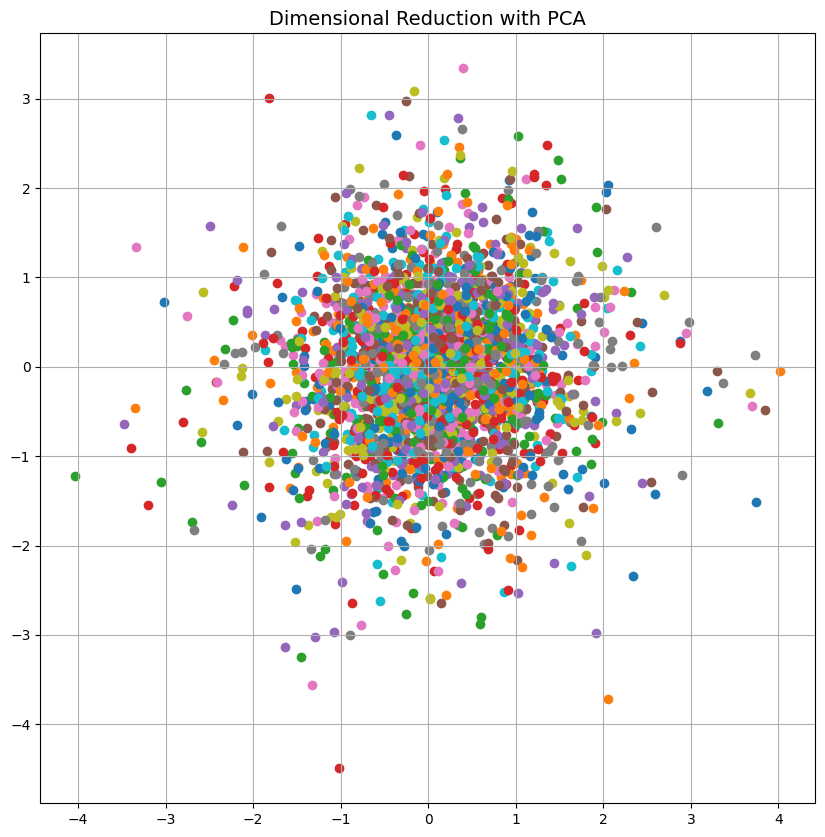

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Convert word vectors into a 2D array of shape (number_of_words, dimensions_of_vectors)
word_vectors_matrix = np.array(word_vectors)

# Initialize and fit PCA
pca = PCA(n_components=2)
word_vectors_2d = pca.fit_transform(word_vectors_matrix)


plt.figure(figsize=(10, 10))

# Iterate over both words and vectors
for vec, word in zip(word_vectors, words):
    plt.scatter(vec[0], vec[1])
    # Optionally, uncomment the next line to display the text labels
    #but it can be a mess of text!!
    # plt.text(vec[0]+0.00, vec[1]+0.00, word, fontsize=9)

# Set the limits to zoom in
# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)
plt.title("Dimensional Reduction with PCA", fontsize=14)
plt.grid(True)
plt.show()


In [120]:
# Example usage (specify the grid boundaries as needed)
x_min, x_max = -0.1, 0.1  # Example boundaries
y_min, y_max = -0.1, 0.1  # Example boundaries
words_in_grid = find_words_in_grid(word_vectors_2d, words, x_min, x_max, y_min, y_max)

words_in_grid[0:]

['country',
 'away',
 'sustained',
 'deny',
 'yield',
 'impose',
 'affect',
 'escape',
 'parallel',
 'defending',
 'confined',
 'misunderstanding']

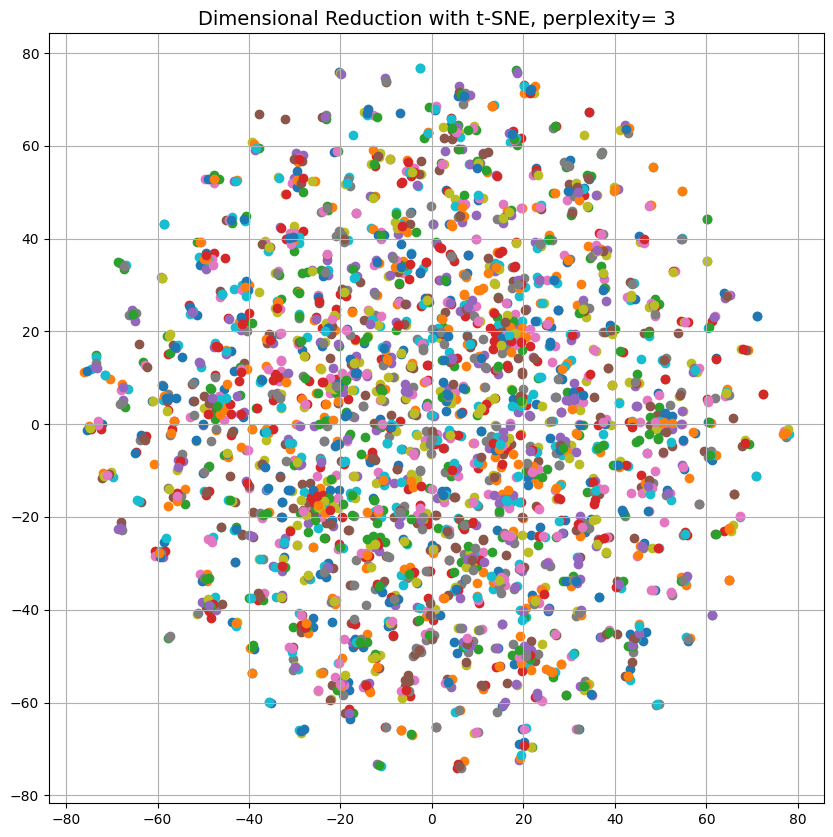

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming 'word_vectors' is your list or array of vectors
# and 'words' is the list of words corresponding to each vector
word_vectors_matrix = np.array(word_vectors)

# Initialize and fit t-SNE, you can adjust parameters like perplexity as needed
perplexity_value = 3  # Adjust this value as needed
tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=0)
word_vectors_2d = tsne.fit_transform(word_vectors_matrix)

# Plotting
plt.figure(figsize=(10, 10))

# Iterate over both words and vectors
for vec, word in zip(word_vectors_2d, words):
    plt.scatter(vec[0], vec[1])
    # plt.text(vec[0]+0.00, vec[1]+0.02, word, fontsize=9)  # Adjust text position if necessary

# Optional: set limits if you want to zoom in, can be helpful if points overlap too much
# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)
plt.title(f"Dimensional Reduction with t-SNE, perplexity= {perplexity_value}", fontsize=14)
plt.grid(True)
plt.show()


In [ ]:
# Example usage (specify the grid boundaries as needed)
x_min, x_max = -10, 10  # Example boundaries
y_min, y_max = -10, 10  # Example boundaries
words_in_grid = find_words_in_grid(word_vectors_2d, words, x_min, x_max, y_min, y_max)

words_in_grid[0:]

In [15]:
!pip install umap-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.2 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=aa3398b73975d68adfdff34211a3da5b27e812e26d18edd689b190c8c5fb799f
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


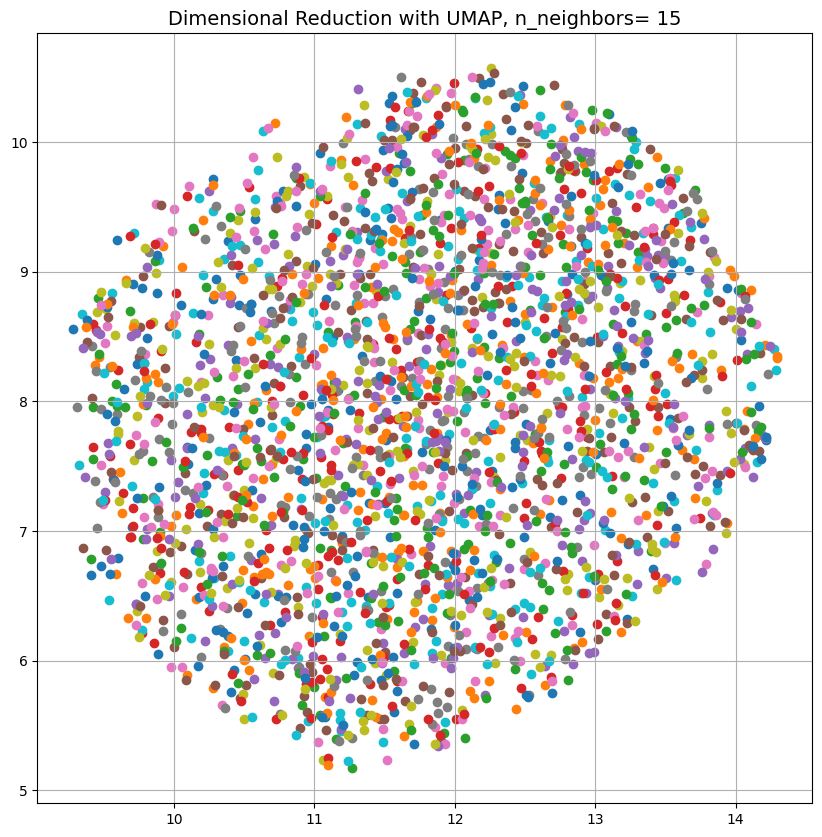

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import umap

# Assuming 'word_vectors' is your list or array of vectors
# and 'words' is the list of words corresponding to each vector
word_vectors_matrix = np.array(word_vectors)

# Initialize and fit UMAP
n_neighbors_value = 15  # Similar to the perplexity in t-SNE, adjust this value as needed
min_dist_value = 0.1  # Minimum distance between embedded points
umap_model = umap.UMAP(n_components=2, n_neighbors=n_neighbors_value, min_dist=min_dist_value)
word_vectors_2d = umap_model.fit_transform(word_vectors_matrix)

# Plotting
plt.figure(figsize=(10, 10))

# Iterate over both words and vectors
for vec, word in zip(word_vectors_2d, words):
    plt.scatter(vec[0], vec[1])
    # plt.text(vec[0]+0.00, vec[1]+0.02, word, fontsize=9)  # Adjust text position if necessary

# Optional: set limits if you want to zoom in, can be helpful if points overlap too much
# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)
plt.title(f"Dimensional Reduction with UMAP, n_neighbors= {n_neighbors_value}", fontsize=14)
plt.grid(True)
plt.show()

